# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

2024-07-22 18:48:59.663541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading Data

In [2]:
# Load data
data = pd.read_csv('tokyo_electricity_final_dataset_half_hourly.csv')

# Parse date and time (assuming data is already loaded into 'data' DataFrame)
data['datetime'] = pd.to_datetime(data['datetime'], format='mixed')
data.set_index('datetime', inplace=True)

# Ensure there are no infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Feature Engineering

In [3]:
# Feature transformation
# Min-Max Scaling for the target variable and features
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Separate features and target
features = data[['electricity_demand', 'solar_generation', 'wind_generation']]
target = data['actual_electricity_price'].values.reshape(-1, 1)

# Scale features and target
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Convert scaled data back to DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=data.index)
target_scaled = pd.DataFrame(target_scaled, columns=['actual_electricity_price'], index=data.index)

# Combine scaled features and target
data_scaled = pd.concat([features_scaled, target_scaled], axis=1)

# Lagged features & Feature selection using Mutual Information

In [4]:
# Generate lagged features
for lag in [1, 2, 3, 7, 14, 28]:
    data_scaled[f'price_act_lag_{lag}'] = data_scaled['actual_electricity_price'].shift(lag)
    data_scaled[f'electricity_demand_lag_{lag}'] = data_scaled['electricity_demand'].shift(lag)
    data_scaled[f'solar_generation_lag_{lag}'] = data_scaled['solar_generation'].shift(lag)
    data_scaled[f'wind_generation_lag_{lag}'] = data_scaled['wind_generation'].shift(lag)

# Drop NaN values introduced by lagging
data_scaled.dropna(inplace=True)

# Split the data into features and target
X = data_scaled.drop(columns=['actual_electricity_price'])
y = data_scaled['actual_electricity_price']

# Apply Mutual Information for feature selection
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select top features based on Mutual Information score
top_features = mi_scores.head(10).index  # You can adjust the number of top features

X_selected = X[top_features]

# Split Data into train and test 

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, shuffle=False)

# Reshape input to be 3D [samples, timesteps, features] for GRU
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=7, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=2, shuffle=False)

# Predict
y_pred = model.predict(X_test_reshaped)

Epoch 1/7
1496/1496 - 5s - loss: 0.0036 - val_loss: 8.0588e-05 - 5s/epoch - 3ms/step
Epoch 2/7
1496/1496 - 3s - loss: 5.3311e-04 - val_loss: 4.4976e-05 - 3s/epoch - 2ms/step
Epoch 3/7
1496/1496 - 3s - loss: 4.1098e-04 - val_loss: 4.5619e-05 - 3s/epoch - 2ms/step
Epoch 4/7
1496/1496 - 3s - loss: 3.8235e-04 - val_loss: 4.6185e-05 - 3s/epoch - 2ms/step
Epoch 5/7
1496/1496 - 3s - loss: 3.6793e-04 - val_loss: 5.0311e-05 - 3s/epoch - 2ms/step
Epoch 6/7
1496/1496 - 3s - loss: 3.5123e-04 - val_loss: 5.2719e-05 - 3s/epoch - 2ms/step
Epoch 7/7
1496/1496 - 3s - loss: 3.4086e-04 - val_loss: 5.4591e-05 - 3s/epoch - 2ms/step
374/374 [==============================] - 1s 1ms/step


# Evaluation of RMSE value

RMSE: 1.8618528665049479


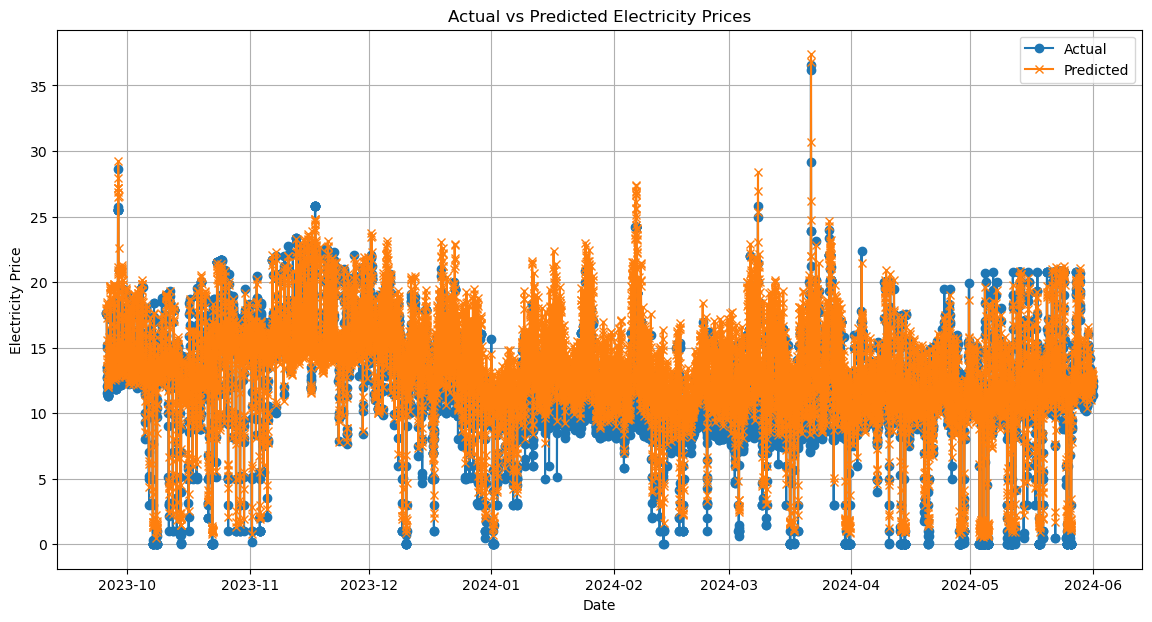

In [6]:
# Inverse scaling to get actual values
y_test_inv = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {rmse}')
# Plotting actual vs predicted prices
plt.figure(figsize=(14, 7))

# Plotting actual prices
plt.plot(data.index[-len(y_test):], y_test_inv, label='Actual', marker='o')

# Plotting predicted prices
plt.plot(data.index[-len(y_test):], y_pred_inv, label='Predicted', marker='x')

plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)
plt.show()